In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

from models import Actor, Critic
%load_ext autoreload
%autoreload 2

In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 100

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def process_rewards(rewards):
    ''' Converts our rewards history into cumulative discounted rewards
    Args:
    - rewards (Array): array of rewards 
    
    Returns:
    - G (Array): array of cumulative discounted rewards
    '''
    #Calculate Gt (cumulative discounted rewards)
    G = []
    
    #track cumulative reward
    total_r = 0
    
    #iterate rewards from Gt to G0
    for r in reversed(rewards):
        
        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r * DISCOUNT_FACTOR
        
        #add to front of G
        G.insert(0, total_r)
    
    #whitening rewards
    G = torch.tensor(G)
    G = (G - G.mean())/G.std()
    
    return G

In [7]:
#Make environment
env = gym.make('CartPole-v1')

#Init network
actor = Actor(env.observation_space.shape[0], env.action_space.n)
critic = Critic(env.observation_space.shape[0])


#Init optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-2)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-2)

#track scores
scores = []

#recent 100 scores
recent_scores = deque(maxlen=100)

#iterate through episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state = env.reset()
    trajectory = []
    score = 0
    isTerminal = False
    
    #generate episode
    while not isTerminal:
        action, log_prob = actor.sample_action(state)
        state_prime, reward, isTerminal, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, log_prob])
            
        state = state_prime
    
    #append score
    scores.append(score)
    recent_scores.append(score)
    
    #check if agent finished training
    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            break
    
    
    # Clear Gradient
    critic_optimizer.zero_grad()
    actor_optimizer.zero_grad()
    
    # Actor
    states, actions, rewards, log_probs = map(list, zip(*trajectory))
    G = process_rewards(rewards)
    state_vals = critic(torch.tensor(states)).reshape(-1)
    actor_loss = F.mse_loss(state_vals, G)
    actor_loss.backward()
    
    # Critic
    critic_loss = Critic.reinforce_baseline_loss(G, state_vals, log_probs)
    critic_loss.backward()
    
    # Update Params
    critic_optimizer.step()
    actor_optimizer.step()
    

env.close()

/tmp/ipykernel_2729/472593105.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plotting training score:

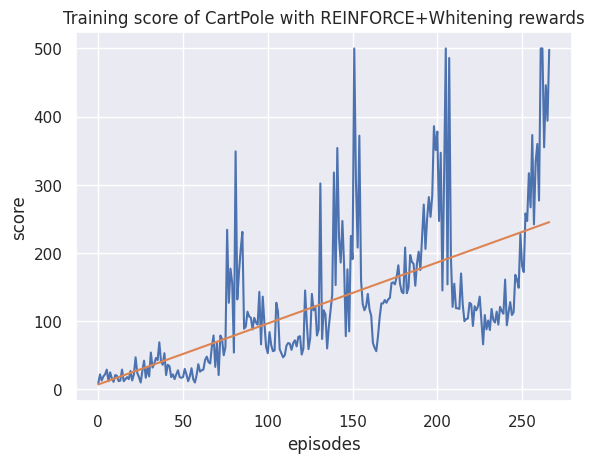

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE+Whitening rewards')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

# Grid World

In [ ]:
#Make environment
env = GridWorldEnv()

#Init network
actor = Actor(1, env.action_space.n)
critic = Critic(1)


#Init optimizer
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

#track scores
scores = []

#recent 100 scores
recent_scores = deque(maxlen=100)

#iterate through episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state = env.reset()
    trajectory = []
    score = 0
    
    #generate episode
    for step in range(20):
        state = torch.nn.functional.one_hot(torch.tensor(state), num_classes=25)
        action, log_prob = actor.sample_action(state)
        state_prime, reward, isTerminal, _ = env.step(action)
        score += reward
        trajectory.append([state, action, reward, log_prob])
        
        if isTerminal:
            break
            
        state = state_prime
    
    #append score
    scores.append(score)
    recent_scores.append(score)
    
    #check if agent finished training
    if len(recent_scores) == 100:
        average = sum(recent_scores)/len(recent_scores)
        if average >= SOLVED_SCORE:
            break
    
    
    # Clear Gradient
    critic_optimizer.zero_grad()
    actor_optimizer.zero_grad()
    
    # Actor
    states, actions, rewards, log_probs = map(list, zip(*trajectory))
    G = process_rewards(rewards)
    state_vals = critic(torch.tensor(states, dtype=torch.float).reshape(-1, 1)).reshape(-1)
    actor_loss = F.mse_loss(state_vals, G)
    actor_loss.backward()
    
    # Critic
    critic_loss = Critic.reinforce_baseline_loss(G, state_vals, log_probs)
    critic_loss.backward()
    
    # Update Params
    torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1)
    critic_optimizer.step()
    actor_optimizer.step()
    print("----" * 30)
    

env.close()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE+Whitening rewards')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()